Restoring offline with a salt flux - after Dougie's fixed the bug.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import shutil as shutil

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35385/status,
Dashboard: /proxy/35385/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39723,Workers: 0
Dashboard: /proxy/35385/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40247,Total threads: 1
Dashboard: /proxy/35285/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:46255,


In [11]:
path_rest_on = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output*/*ocean_month.nc'))[24:30]
path_rest_pc = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-prsc-rest-TESTS/output*/*ocean_month.nc'))

In [13]:
def preprocess(ds):
    ds = ds['salt_flux_added']
    return ds

In [14]:
sfa_rest_on = xr.open_mfdataset(path_rest_on, preprocess=preprocess, parallel=True, chunks='auto')['salt_flux_added']
sfa_rest_pc = xr.open_mfdataset(path_rest_pc, preprocess=preprocess, parallel=True, chunks='auto')['salt_flux_added']

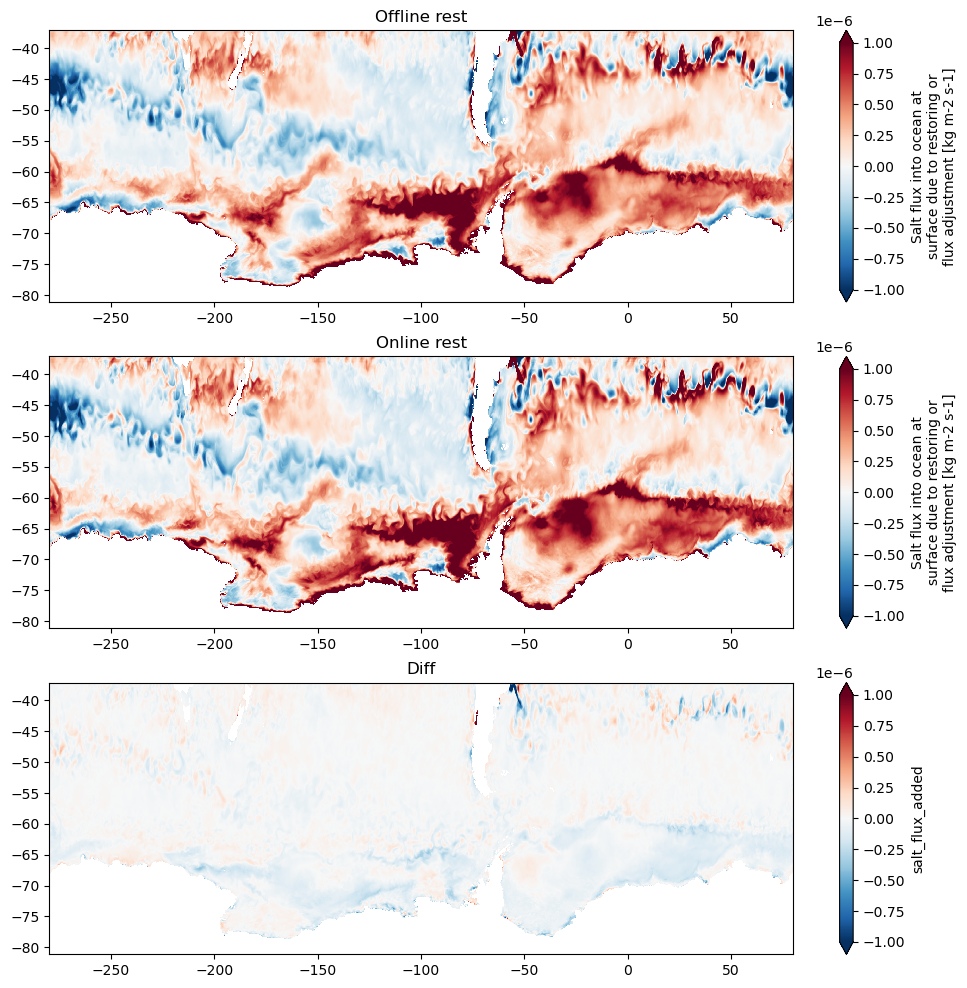

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
vmin=-1e-6; vmax=1e-6;

(sfa_rest_pc.isel(time=0)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Offline rest')
(sfa_rest_on.isel(time=0)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Online rest')
(sfa_rest_pc.isel(time=0)-sfa_rest_on.isel(time=0)).plot(ax=axs[2], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[2].set_title('Diff');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');

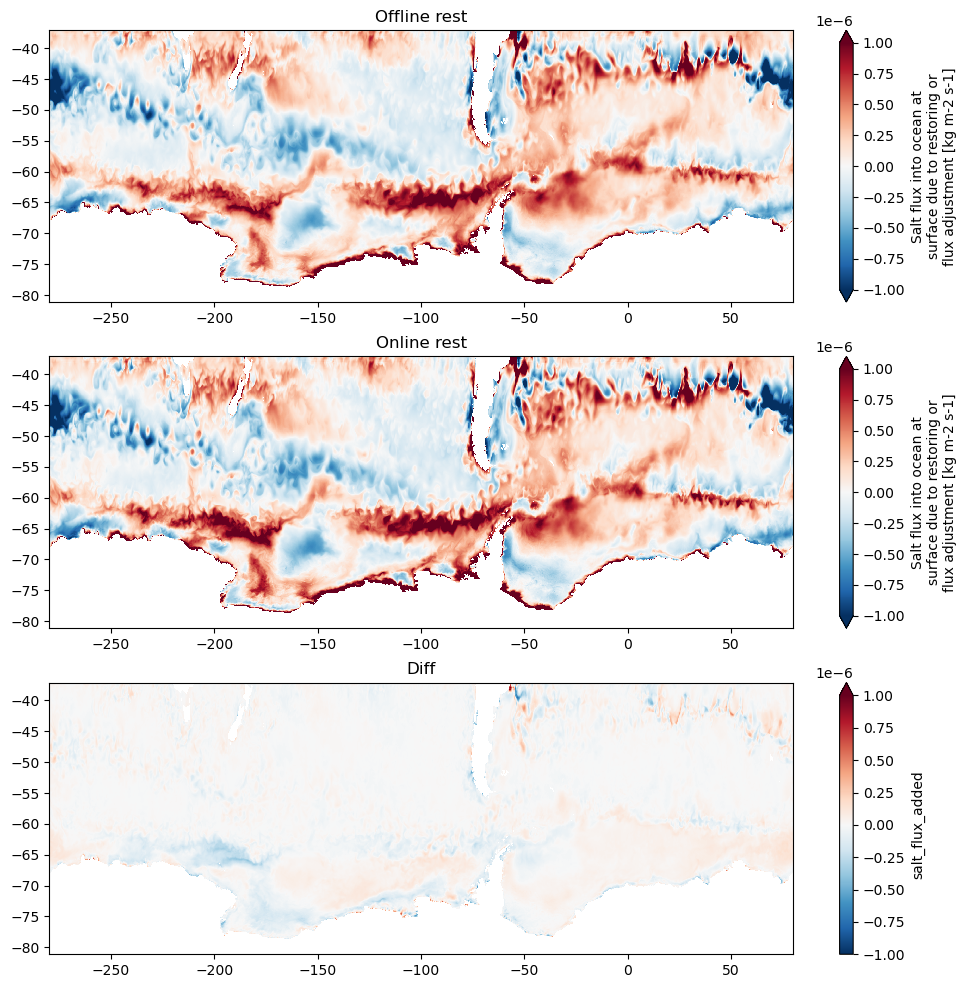

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
vmin=-1e-6; vmax=1e-6;

(sfa_rest_pc.isel(time=-1)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Offline rest')
(sfa_rest_on.isel(time=-1)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Online rest')
(sfa_rest_pc.isel(time=-1)-sfa_rest_on.isel(time=-1)).plot(ax=axs[2], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[2].set_title('Diff');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');

Check salt

In [19]:
path_rest_on = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output*/*ocean_month_z.nc'))[24:30]
path_rest_pc = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-prsc-rest-TESTS/output*/*ocean_month_z.nc'))

In [20]:
def preprocess(ds):
    ds = ds['so'].isel(z_l=0)
    return ds

In [21]:
so_rest_on = xr.open_mfdataset(path_rest_on, preprocess=preprocess, parallel=True, chunks='auto')['so']
so_rest_pc = xr.open_mfdataset(path_rest_pc, preprocess=preprocess, parallel=True, chunks='auto')['so']

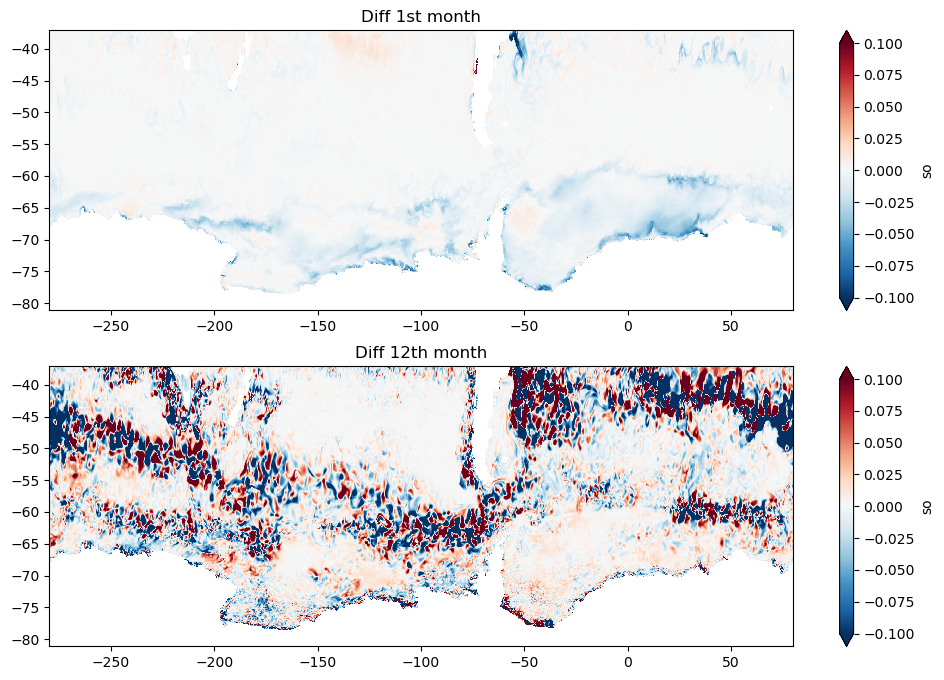

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
vmin=-.1; vmax=.1;

(so_rest_pc.isel(time=0)-so_rest_on.isel(time=0)).plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[0].set_title('Diff 1st month');
(so_rest_pc.isel(time=-1)-so_rest_on.isel(time=-1)).plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu_r'); axs[1].set_title('Diff 12th month');
for ax in axs:
    ax.set_xlabel(''); ax.set_ylabel('');

Quick average over the shelf

In [25]:
area = xr.open_dataset('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-prsc-rest-TESTS/output020/20010101.ocean_static.nc')['areacello']
shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']
shelf_mask = xr.where(shelf_mask!=-1000,1,np.nan)

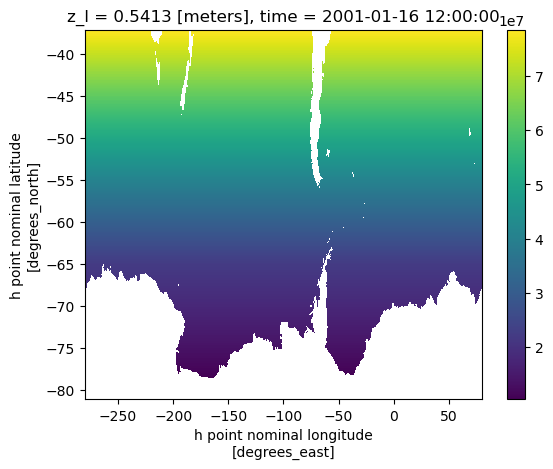

In [26]:
area = area*(so_rest_pc.isel(time=0)*0+1)
area.plot()

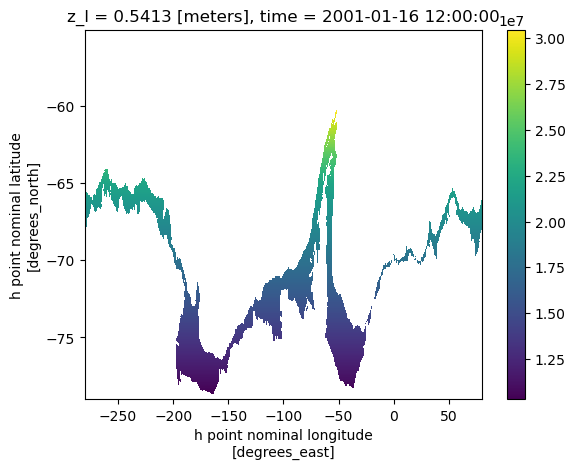

In [27]:
(area*shelf_mask).plot()

In [28]:
area_shelf = (area*shelf_mask).sum(['xh', 'yh'])
sfa_rest_on_int = (sfa_rest_on*area*shelf_mask).sum(['xh', 'yh'])/area_shelf
sfa_rest_pc_int = (sfa_rest_pc*area*shelf_mask).sum(['xh', 'yh'])/area_shelf
so_rest_on_int = (so_rest_on*area*shelf_mask).sum(['xh', 'yh'])/area_shelf
so_rest_pc_int = (so_rest_pc*area*shelf_mask).sum(['xh', 'yh'])/area_shelf

Text(0.5, 1.0, 'salt_flux_added, Ant. shelf')

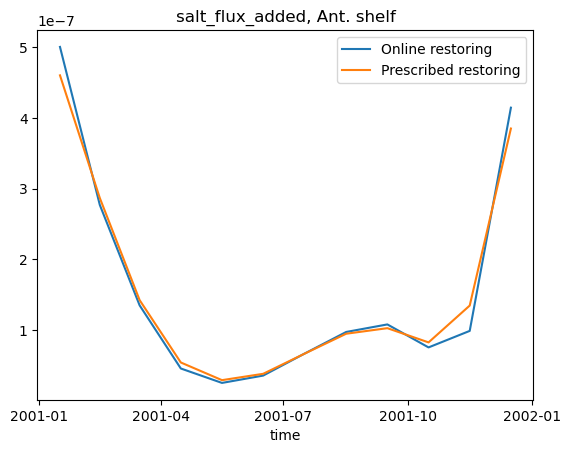

In [29]:
sfa_rest_on_int.plot(label='Online restoring')
sfa_rest_pc_int.plot(label='Prescribed restoring')
plt.legend(); plt.title('salt_flux_added, Ant. shelf')

Text(0.5, 1.0, 'surface_salt, Ant. shelf')

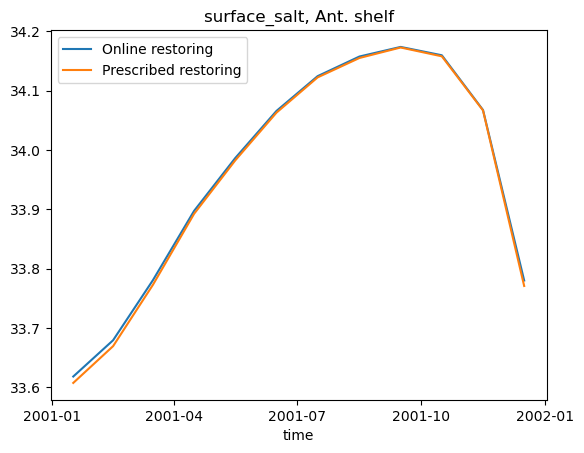

In [30]:
so_rest_on_int.plot(label='Online restoring')
so_rest_pc_int.plot(label='Prescribed restoring')
plt.legend(); plt.title('surface_salt, Ant. shelf')